## Import necessary packages

In [1]:
import copy
import json
import logging
import numpy as np
import os
import pandas as pd
import pickle
import random
import string
import sys
import torch
import torchaudio
import tqdm

from utils import (
    add_gaussian_noise_to_audio,
    add_score_metrics,
    adjust_pauses,
    common_indexes,
    configure_model,
    configure_model_generation,
    find_matching_indexes,
    get_alignment_head_generator,
    get_processor_config_genConfig,
    get_mixing_scale,
    load_labels,
    prepare_ground_truth,
    process_audio_files,
    remove_punctuation,
    setup_pipeline,
    top_heads_by_f1
)
from pathlib import Path
from evaluate_word_segmentation import (
    convert_timestamps_from_labels_json_to_TimestampedOutput,
    convert_timestamps_from_transformers_pipe_to_TimestampedOutput,
    batch_evaluate_segmentation,
)
from crisper_whisper import (
    WhisperForConditionalGenerationWithAttentionLoss
)

from speech_recognition import WhisperXModel, WhisperTimestamped, ModelConfig, transcribe_speech_files
from transformers import (
    AutoConfig, 
    AutoProcessor, 
    WhisperProcessor, 
    AutoModelForSpeechSeq2Seq, 
    GenerationConfig, 
    pipeline
)

from typing import Dict, Generator, List


/home/azureuser/.conda/envs/crisper_whisper/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/azureuser/.conda/envs/crisper_whisper/lib/python3.10/site-packages/pyannote/audio/core/io.py:43: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



## Set a Experiment Configuration Documentation

This document outlines the parameters used in the configuration for Whisper models used in the experiments. Each key in the `experiment_config` dictionary holds specific experimental settings as detailed below:

### Models
- **`models`**: List of transformer Whisper models to be evaluated. Each entry is a dictionary specifying the model's name and path e.g.:
  - **`name`**: "large-v3" — points to a pre-trained model at **`path`**: "openai/whisper-large-v3".


### Output Path
- **`output_path`**: Path where experiment outputs are stored, set to `"interspeech_2024/timing_outputs_head_selection/"`.

### Dataset Configuration
- **`dataset_base_path`**: Base path to the datasets used in experiments, `/home/azureuser/data/english_speech`.

### Head Selection Configuration
- **`head_selection_dataset`**: The dataset used for head selection, specifically `"timit"` is chosen for its good timestamp quality.
- **`head_selection_collar`**: The collar size in seconds for the head selection phase, set to `0.1`.
- **`head_selection_num_samples`**: Number of samples used in the head selection phase, `100`.

### Experiment Parameters
- **`experiment_num_samples`**: Number of samples to use in each of the datasets for the main experiments, `500`.
- **`test_datasets`**: List of datasets to be used in experiments: `["timit", "ami_hf", "cv_14"]`.
- **`median_filter_widths`**: List of widths for the median filter applied in processing the DTW Matrix.
- **`num_heads`**: Number of greedily picked best performing heads to test.
- **`add_noise`**: Specifies which noise configurations should be tested. `[True]` means with noise shall be tested  and `[False]` means without noise shall be tested. Botch configurations should be testes `[True, False]`.
- **`transcripts_must_match`**: Whether the transcripts need to match exactly in the evaluation for timestamps, set to `True`.
- **`pause_thresholds`**: Numpy array of pause threshold values to test for splitting artefact pauses.
- **`collars`**: List of collar values in seconds for caluclating precision, recall and f1 scores.

### Additional Settings
- **`device`**: The device where the model is placed for the experiments: `"cuda:0"`.


In [5]:
experiment_config = {
    "models": [
        {"name": "large-v3", "path": "openai/whisper-large-v3"},
        {"name": "large-v2", "path": "openai/whisper-large-v2"},
        {"name": "crisperWhisper++", "path": "/home/azureuser/laurin/code/research/output/crisper_whisper_timestamp_finetuned"}
    ],
    "output_path": "experiments",
    "dataset_base_path": "/home/azureuser/data/english_speech",
    "head_selection_dataset": "timit",
    "head_selection_collar": .1,
    "head_selection_num_samples": 100,
    "experiment_num_samples": 500,
    "test_datasets": ["synthetic_no_fillers_long_pauses","timit", "ami_hf", "cv_14"],
    "device": "cuda:0",
    "median_filter_widths": [1,3,5,7,9],
    "num_heads": list(range(1,15)),
    "add_noise": [False],
    "transcripts_must_match": True,
    "pause_thresholds": np.linspace(0, 0.2, 5),
    "collars":[float(x) / 20 for x in range(1,21)]
}

# Create output directory if it doesn't exist
os.makedirs(experiment_config['output_path'], exist_ok=True)


## Get F1 scores and other metrics for Models defined in the Experiment Configuration

In this section, we extract the F1 segmentation Scores on a subset of a dataset for each individiual head of the decoder.

In [28]:
import logging

for model_config in experiment_config['models']:
    model_name = model_config['name']
    model_path = model_config['path']
    model = configure_model(model_path, experiment_config['device'])
    processor, config, generation_config = get_processor_config_genConfig(model_path)
    alignment_head_generator = get_alignment_head_generator(32, 20)
    
    for alignment_heads in tqdm.tqdm(alignment_head_generator, desc=f'Processing {model_name}'):
        configure_model_generation(model, model_name, processor, alignment_heads, 7)
        labels = load_labels(experiment_config['dataset_base_path'], experiment_config['head_selection_dataset'],'test', experiment_config['head_selection_num_samples'])
        ground_truth_transcripts_and_timestamps = prepare_ground_truth(labels)
        asr_pipeline = setup_pipeline(model, processor, experiment_config['device'])
        
        audio_paths = [os.path.join(experiment_config['dataset_base_path'],
                                    experiment_config['head_selection_dataset'],
                                    label['audio']) for label in labels]
        try:
            predictions, success_ids = process_audio_files(audio_paths, asr_pipeline)
            ground_truth_transcripts_and_timestamps = [ground_truth_transcripts_and_timesamps[i] for i in success_ids]
            
        
            predicted_transcripts_and_timestamps = [
                (
                    prediction["text"],
                    convert_timestamps_from_transformers_pipe_to_TimestampedOutput(prediction["chunks"])
                )
                for prediction in predictions
            ]
            
            new_predictions = adjust_pauses(predicted_transcripts_and_timestamps)
            seg_metrics, _ = batch_evaluate_segmentation(
                ground_truth_transcripts_and_timestamps,
                new_predictions,
                collar=experiment_config['head_selection_collar'],
                transcripts_must_match=experiment_config['transcripts_must_match']
            )
            
            results.append({
                'model': model_name,
                'heads': alignment_heads, 
                f'F1_collar.{experiment_config["head_selection_collar"]}': seg_metrics.f1_score,
                f'avg_iou_collar.{experiment_config["head_selection_collar"]}': seg_metrics.avg_iou
            })
        except Exception as e:
            print(e)
            

with open(os.path.join(experiment_config['output_path'], 'head_results.json'), 'w') as f:
    json.dump(results, f, ensure_ascii=False, indent=4)

Processing large-v3: 0it [00:03, ?it/s]


KeyboardInterrupt: 

## Calculate results to run ablation studies on heads

In this section, we will calculate the results when greedily adding ,,the best" heads from the previous run. Further we will vary various hyperparameters that might have a influence on the segmentation so we are able to perform ablation studies.

In [3]:
with open(os.path.join(experiment_config['output_path'],'head_results.json'), 'r') as f:
    result = json.load(f)
head_df = pd.DataFrame(result)

In [ ]:
# Set logging level to CRITICAL to suppress all other log messages
logging.getLogger("transformers").setLevel(logging.CRITICAL)
results = []
output = []
for model_config in tqdm.tqdm(experiment_config['models']):
    print(f'working on {model_config}')
    model_name = model_config['name']
    model_path = model_config['path']
    model = configure_model(model_path, experiment_config["device"])
    processor, config, generation_config = get_processor_config_genConfig(model_path)
 
    for dataset in experiment_config["test_datasets"]:
        print(f'working on {dataset}')
        for add_noise in experiment_config["add_noise"]:
            for median_filter_width in experiment_config["median_filter_widths"]:
                for num_heads in experiment_config["num_heads"]:
                    top_heads_dict = top_heads_by_f1(head_df, num_heads, experiment_config["head_selection_collar"])
                    alignment_heads = top_heads_dict[model_name]
                    configure_model_generation(model, model_name, processor, alignment_heads, median_filter_width)
                    labels = load_labels(experiment_config["dataset_base_path"],
                                         dataset,
                                         split='test',
                                         limit=experiment_config["experiment_num_samples"])
                    ground_truth_transcripts_and_timestamps = prepare_ground_truth(labels)
                    asr_pipeline = setup_pipeline(model, processor, experiment_config["device"])
                    audio_paths = [os.path.join(experiment_config["dataset_base_path"], dataset, label['audio']) for label in labels]
                    if add_noise:
                        audio_paths = [add_gaussian_noise_to_audio(path, random.randint(1,8)) for path in audio_paths]


                    predictions, success_ids = process_audio_files(audio_paths, asr_pipeline)
                    ground_truth_transcripts_and_timestamps = [ground_truth_transcripts_and_timestamps[i] for i in success_ids]
                    
                    
                    predicted_transcripts_and_timestamps = [
                        (
                            prediction["text"],
                            convert_timestamps_from_transformers_pipe_to_TimestampedOutput(prediction["chunks"])
                        )
                        for prediction in predictions
                    ]
                    for threshold in experiment_config["pause_thresholds"]:
                        new_predictions = adjust_pauses(predicted_transcripts_and_timestamps, threshold=threshold)          
                        for collar in experiment_config["collars"]:
                            seg_metrics, seg_metrics_list = batch_evaluate_segmentation(
                                ground_truth_transcripts_and_timestamps,
                                new_predictions,
                                collar=collar,
                                transcripts_must_match=experiment_config["transcripts_must_match"]
                            )
                            addendum = '_noise' if add_noise else ''
                            output.append({
                                'Threshold': threshold,
                                'Collar': collar,
                                'Model': f'{model_name}',
                                'MedianFilterWidth' : median_filter_width,
                                'Dataset': dataset + addendum,
                                'Recall': seg_metrics.recall,
                                'Precision': seg_metrics.precision,
                                'F1 Score': seg_metrics.f1_score,
                                'Avg IOU': seg_metrics.avg_iou,
                                'num_heads': num_heads,
                                'metrics': seg_metrics_list
                            })

with open(os.path.join(experiment_config['output_path'], 'full_ablations.pickle'), 'wb') as f:
    pickle.dump(output, f)

  0%|          | 0/3 [00:00<?, ?it/s]

working on {'name': 'large-v3', 'path': 'openai/whisper-large-v3'}
working on synthetic_no_fillers_long_pauses
working on timit
working on ami_hf
working on cv_14


 33%|███▎      | 1/3 [33:44:10<67:28:20, 121450.03s/it]

working on {'name': 'large-v2', 'path': 'openai/whisper-large-v2'}
working on synthetic_no_fillers_long_pauses
working on timit
working on ami_hf
working on cv_14


In [10]:
df = pd.DataFrame(output)

In [24]:
with open(os.path.join(experiment_config['output_path'], 'full_ablations.pickle'), 'rb') as f:
    output = pickle.load(f)

In [25]:
for element in ouptut:
    del element['metrics']

NameError: name 'ouptut' is not defined

In [11]:
df
# Filter dataframe for Collar == 0.10
filtered_df = df[df["Collar"] == 0.10]

# Group by Model and Dataset, then find the maximum F1 Score and corresponding Avg IOU
result_df = filtered_df.groupby(["Model", "Dataset"]).apply(
    lambda x: x.loc[x["F1 Score"].idxmax(), ["F1 Score", "Avg IOU"]]
).reset_index()


pivoted_df = result_df.pivot(index='Dataset', columns='Model', values=['F1 Score', 'Avg IOU'])

# Flatten the MultiIndex columns
pivoted_df.columns = ['_'.join(col).strip() for col in pivoted_df.columns.values]
pivoted_df.reset_index(inplace=True)

pivoted_df


,Dataset,F1 Score_crisperWhisper++,F1 Score_large-v2,F1 Score_large-v3,Avg IOU_crisperWhisper++,Avg IOU_large-v2,Avg IOU_large-v3
0,ami_hf,0.902851,0.848524,0.855826,0.858678,0.739689,0.765726
1,cv_14,0.818483,0.518021,0.610142,0.818454,0.742828,0.765486
2,synthetic_no_fillers_long_pauses,0.852555,0.579134,0.693468,0.740071,0.659972,0.677428
3,timit,0.798538,0.676210,0.727145,0.834722,0.746986,0.785171


In [12]:
with open(os.path.join(experiment_config['output_path'], 'full_ablations.pickle'), 'wb') as f:
    pickle.dump(output, f)

## Optional: Get Baseline Performance of WhisperTimestamped and WhisperX

In this section, we can additionally compute the baseline performance for:

- **WhisperTimestamped:** [GitHub Repository](https://github.com/linto-ai/whisper-timestamped/)
- **WhisperX:** [GitHub Repository](https://github.com/m-bain/whisperX)


In [120]:
baseline_output=[]
for i,model_config in enumerate([ModelConfig.TIMESTAMPED_WHISPER, ModelConfig.WHISPER_X]):
    if i == 1:
        model = WhisperXModel(**model_config)
    elif i == 0:
        model = WhisperTimestamped(**model_config)
    for dataset in experiment_config["test_datasets"]:
        for add_noise in experiment_config["add_noise"]:
            labels = load_labels(experiment_config["dataset_base_path"],
                                 dataset,
                                 split='test',
                                 limit= experiment_config["experiment_num_samples"])
            audio_paths = [os.path.join(experiment_config["dataset_base_path"], dataset, label['audio']) for label in labels]
            if add_noise:
                audio_paths = [add_gaussian_noise_to_audio(path, random.randint(1,8)) for path in audio_paths]
                        
            outputs, error_ids = transcribe_speech_files(model=model, dataset_name=dataset, audio_paths=audio_paths)
            
            timestamped_outputs = [(output.prediction_str,output.timestamped_outputs) for output in outputs]
            labels = [label for label in labels if os.path.join(experiment_config["dataset_base_path"], dataset, label['audio']) not in error_ids]
            ground_truth_transcripts_and_timestamps = prepare_ground_truth(labels)
            for collar in experiment_config["collars"]:
                seg_metrics, seg_metrics_list = batch_evaluate_segmentation(
                    ground_truth_transcripts_and_timestamps,
                    timestamped_outputs,
                    collar=collar,
                    transcripts_must_match=experiment_config["transcripts_must_match"]
                )
                addendum = '_noise' if add_noise else ''
                baseline_output.append({
                    'Threshold': None,
                    'Collar': collar,
                    'Model': 'WhisperX' if i==1 else 'WhisperTimestamped',
                    'MedianFilterWidth' : None,
                    'Dataset': dataset + addendum,
                    'Recall': seg_metrics.recall,
                    'Precision': seg_metrics.precision,
                    'F1 Score': seg_metrics.f1_score,
                    'Avg IOU': seg_metrics.avg_iou,
                    'num_heads': None,
                    'predictions' : outputs,
                    'gts': ground_truth_transcripts_and_timestamps,
                    'metrics': seg_metrics_list
                })


with open(os.path.join(experiment_config['output_path'], 'baseline_ablations.pickle'), 'wb') as f:
    pickle.dump(baseline_output, f)

Transcribing audio files: 100%|██████████| 200/200 [08:49<00:00,  2.65s/it]
Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.2.4. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../.cache/torch/whisperx-vad-segmentation.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.0+cu118. Bad things might happen unless you revert torch to 1.x.


Transcribing audio files:   9%|▉         | 46/500 [00:09<01:18,  5.77it/s]

No active speech found in audio


Transcribing audio files:  13%|█▎        | 66/500 [00:13<01:11,  6.06it/s]

Failed to align segment (" Subs by www.zeoranger.co.uk"): backtrack failed, resorting to original...


Transcribing audio files:  24%|██▎       | 118/500 [00:23<00:57,  6.61it/s]

No active speech found in audio


Transcribing audio files:  52%|█████▏    | 259/500 [00:50<00:37,  6.37it/s]

Failed to align segment (" in the morning."): backtrack failed, resorting to original...


Transcribing audio files:  62%|██████▏   | 309/500 [00:59<00:27,  6.91it/s]

No active speech found in audio


Transcribing audio files:  64%|██████▍   | 320/500 [01:02<00:30,  5.98it/s]

No active speech found in audio


Transcribing audio files:  68%|██████▊   | 338/500 [01:05<00:28,  5.65it/s]

Failed to align segment (" from there."): backtrack failed, resorting to original...


Transcribing audio files:  85%|████████▍ | 423/500 [01:22<00:11,  6.90it/s]

No active speech found in audio


Transcribing audio files:   0%|          | 2/500 [00:00<01:40,  4.94it/s]

Failed to align segment (" 6"): no characters in this segment found in model dictionary, resorting to original...


Transcribing audio files:   7%|▋         | 35/500 [00:07<01:45,  4.42it/s]

No active speech found in audio


Transcribing audio files:  22%|██▏       | 109/500 [00:24<01:08,  5.74it/s]

No active speech found in audio


Transcribing audio files:  31%|███       | 156/500 [00:35<01:07,  5.08it/s]

Failed to align segment (" 3."): no characters in this segment found in model dictionary, resorting to original...


Transcribing audio files: 100%|██████████| 200/200 [01:37<00:00,  2.05it/s]


In [123]:
baseline_df

,Threshold,Collar,Model,MedianFilterWidth,Dataset,Recall,Precision,F1 Score,Avg IOU,num_heads,predictions,gts,metrics
0,None,0.05,WhisperTimestamped,None,timit,0.305768,0.306761,0.306264,0.812889,None,[<speech_recognition.ModelOutput object at 0x7...,[(The bungalow was pleasantly situated near th...,[<evaluate_word_segmentation.PrecisionRecallMe...
1,None,0.10,WhisperTimestamped,None,timit,0.679812,0.682019,0.680914,0.738263,None,[<speech_recognition.ModelOutput object at 0x7...,[(The bungalow was pleasantly situated near th...,[<evaluate_word_segmentation.PrecisionRecallMe...
2,None,0.15,WhisperTimestamped,None,timit,0.896998,0.899911,0.898452,0.701166,None,[<speech_recognition.ModelOutput object at 0x7...,[(The bungalow was pleasantly situated near th...,[<evaluate_word_segmentation.PrecisionRecallMe...
3,None,0.20,WhisperTimestamped,None,timit,0.933785,0.936817,0.935298,0.694339,None,[<speech_recognition.ModelOutput object at 0x7...,[(The bungalow was pleasantly situated near th...,[<evaluate_word_segmentation.PrecisionRecallMe...
4,None,0.25,WhisperTimestamped,None,timit,0.959388,0.962504,0.960943,0.688971,None,[<speech_recognition.ModelOutput object at 0x7...,[(The bungalow was pleasantly situated near th...,[<evaluate_word_segmentation.PrecisionRecallMe...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,None,0.80,WhisperX,None,synthetic_no_fillers_long_pauses,0.983519,0.873399,0.925194,0.644109,None,[<speech_recognition.ModelOutput object at 0x7...,"[(Once upon a time ... in a land far, far away...",[<evaluate_word_segmentation.PrecisionRecallMe...
156,None,0.85,WhisperX,None,synthetic_no_fillers_long_pauses,0.983931,0.873765,0.925581,0.643839,None,[<speech_recognition.ModelOutput object at 0x7...,"[(Once upon a time ... in a land far, far away...",[<evaluate_word_segmentation.PrecisionRecallMe...
157,None,0.90,WhisperX,None,synthetic_no_fillers_long_pauses,0.984137,0.873948,0.925775,0.643731,None,[<speech_recognition.ModelOutput object at 0x7...,"[(Once upon a time ... in a land far, far away...",[<evaluate_word_segmentation.PrecisionRecallMe...
158,None,0.95,WhisperX,None,synthetic_no_fillers_long_pauses,0.984961,0.874680,0.926550,0.643193,None,[<speech_recognition.ModelOutput object at 0x7...,"[(Once upon a time ... in a land far, far away...",[<evaluate_word_segmentation.PrecisionRecallMe...


In [125]:
baseline_df = pd.DataFrame(baseline_output)
df = baseline_df
# Filter dataframe for Collar == 0.20
filtered_df = df[df["Collar"] == 0.20]

# Group by Model and Dataset, then find the maximum F1 Score and corresponding Avg IOU
result_df = filtered_df.groupby(["Model", "Dataset"]).apply(
    lambda x: x.loc[x["F1 Score"].idxmax(), ["F1 Score", "Avg IOU"]]
).reset_index()


pivoted_df = result_df.pivot(index='Dataset', columns='Model', values=['F1 Score', 'Avg IOU'])

# Flatten the MultiIndex columns
pivoted_df.columns = ['_'.join(col).strip() for col in pivoted_df.columns.values]
pivoted_df.reset_index(inplace=True)

pivoted_df

,Dataset,F1 Score_WhisperTimestamped,F1 Score_WhisperX,Avg IOU_WhisperTimestamped,Avg IOU_WhisperX
0,ami_hf,0.847130,0.800508,0.734728,0.583300
1,cv_14,0.745536,0.945909,0.693112,0.619702
2,synthetic_no_fillers_long_pauses,0.773836,0.803876,0.561212,0.661628
3,timit,0.935298,0.985409,0.694339,0.664327


## Visualize Results

In this section, we will load the results from the ablation and visualize them. 

In [16]:
import pickle
import os

with open(os.path.join(experiment_config['output_path'], 'full_ablations.pickle'), 'rb') as f:
    output = pickle.load(f)


In [77]:
pwd

'/home/azureuser/laurin/code/crisper_whisper/run_experiments'

In [13]:
visualization_config = {
    "models_to_compare": ["large-v3","crisperWhisper++", "large-v2"],
    "output_path": "plots",
    "visualization_datasets": ["timit", "ami_hf", "cv_14", "synthetic_no_fillers_long_pauses"],
}

In [14]:
# Create output directory if it doesn't exist
os.makedirs(visualization_config['output_path'], exist_ok=True)

In [15]:
df = pd.DataFrame(output)
df

,Threshold,Collar,Model,MedianFilterWidth,Dataset,Recall,Precision,F1 Score,Avg IOU,num_heads,metrics
0,0.0,0.05,large-v3,1,synthetic_no_fillers_long_pauses,0.238162,0.212046,0.224346,0.684228,1,[<evaluate_word_segmentation.PrecisionRecallMe...
1,0.0,0.10,large-v3,1,synthetic_no_fillers_long_pauses,0.720454,0.641453,0.678662,0.628419,1,[<evaluate_word_segmentation.PrecisionRecallMe...
2,0.0,0.15,large-v3,1,synthetic_no_fillers_long_pauses,0.829686,0.738707,0.781557,0.622256,1,[<evaluate_word_segmentation.PrecisionRecallMe...
3,0.0,0.20,large-v3,1,synthetic_no_fillers_long_pauses,0.870076,0.774668,0.819605,0.618855,1,[<evaluate_word_segmentation.PrecisionRecallMe...
4,0.0,0.25,large-v3,1,synthetic_no_fillers_long_pauses,0.895145,0.796988,0.843220,0.617568,1,[<evaluate_word_segmentation.PrecisionRecallMe...
...,...,...,...,...,...,...,...,...,...,...,...
83995,0.2,0.80,crisperWhisper++,9,cv_14,0.926856,0.925834,0.926345,0.733530,14,[<evaluate_word_segmentation.PrecisionRecallMe...
83996,0.2,0.85,crisperWhisper++,9,cv_14,0.930168,0.929143,0.929655,0.731966,14,[<evaluate_word_segmentation.PrecisionRecallMe...
83997,0.2,0.90,crisperWhisper++,9,cv_14,0.932652,0.931624,0.932138,0.730815,14,[<evaluate_word_segmentation.PrecisionRecallMe...
83998,0.2,0.95,crisperWhisper++,9,cv_14,0.937069,0.936035,0.936552,0.728950,14,[<evaluate_word_segmentation.PrecisionRecallMe...


In [16]:
# Apply the function to each row in the DataFrame for each dataset
df['matching_indexes'] = df.apply(find_matching_indexes, axis=1)
# Group by 'Model' and 'Dataset' and apply the common_indexes function
common_idx_df = df.groupby(['Model', 'Dataset'])['matching_indexes'].agg(common_indexes).reset_index()

# Merge the common indexes back into the original DataFrame
df = pd.merge(df, common_idx_df, on=['Model', 'Dataset'], suffixes=('', '_common'))
df['F1 Score clean'] = df.apply(lambda row: add_score_metrics(row, 'f1_score'), axis=1)
df['Avg IOU clean'] = df.apply(lambda row: add_score_metrics(row, 'avg_iou'), axis=1)


KeyError: 'predictions'

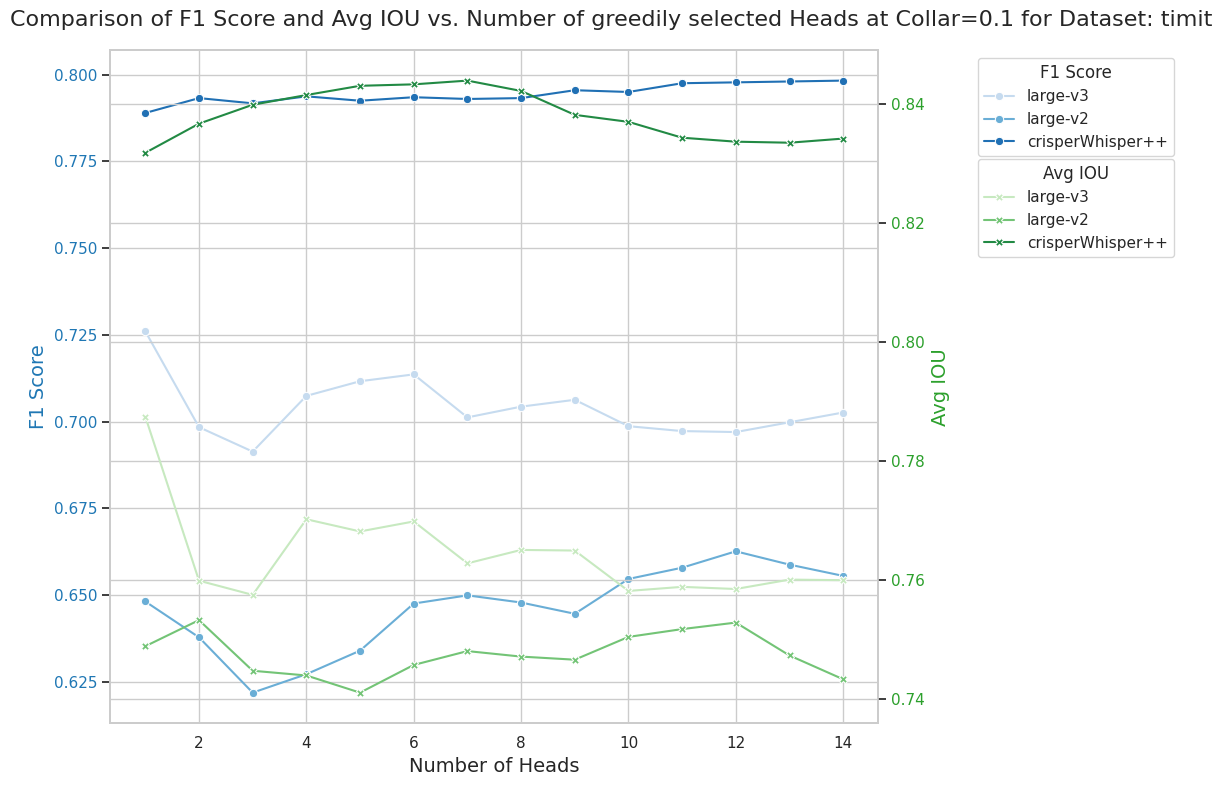

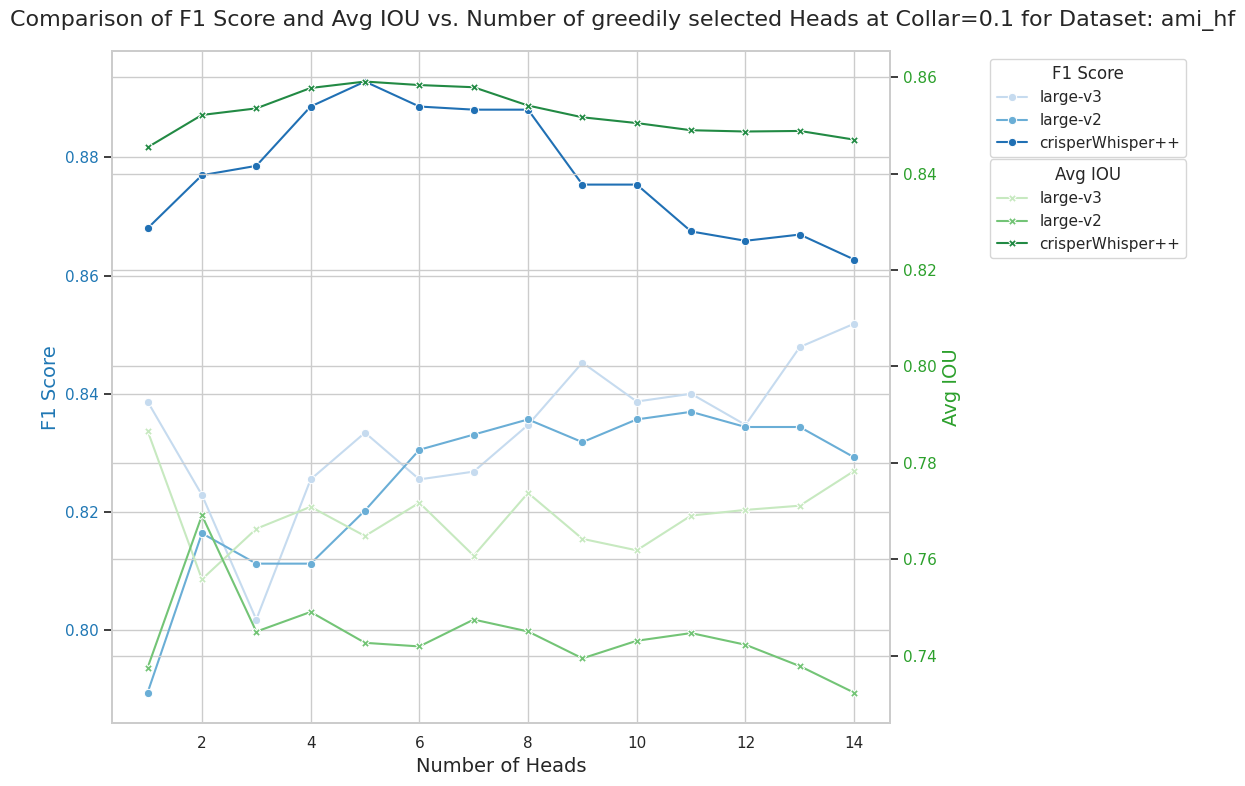

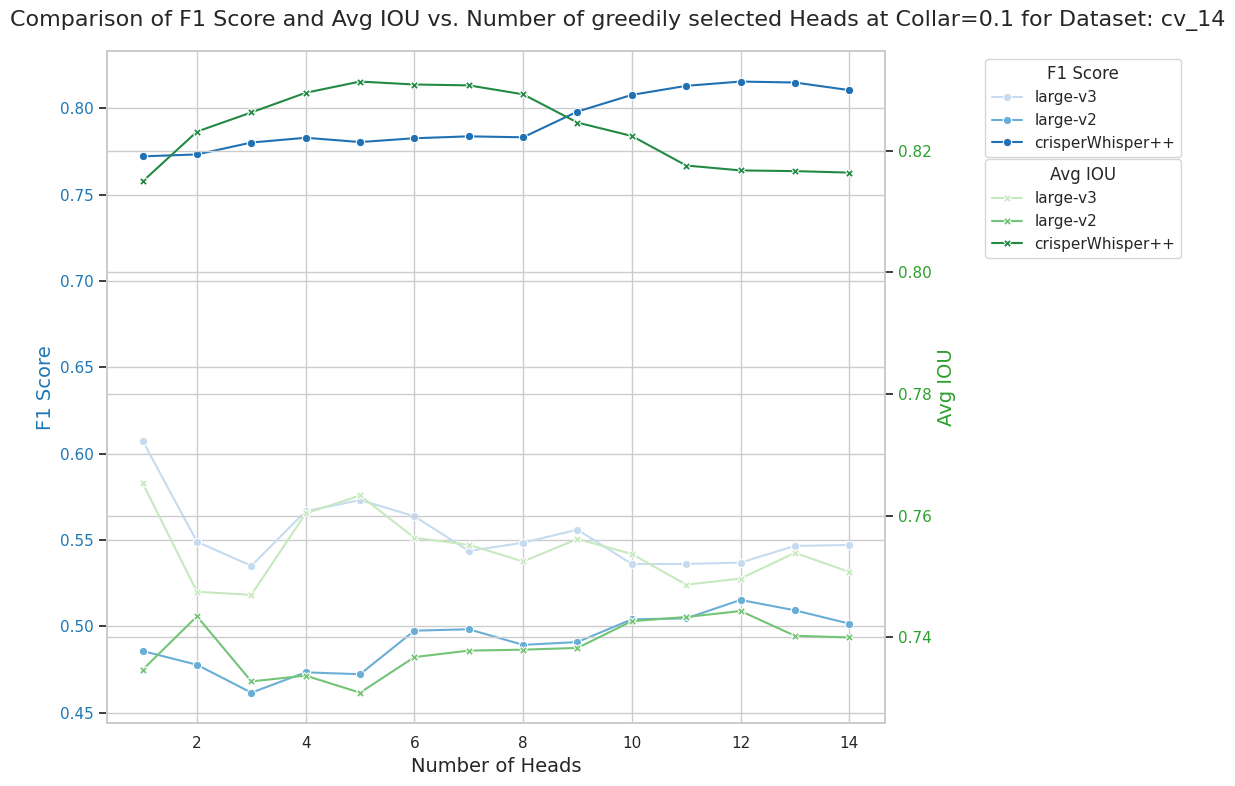

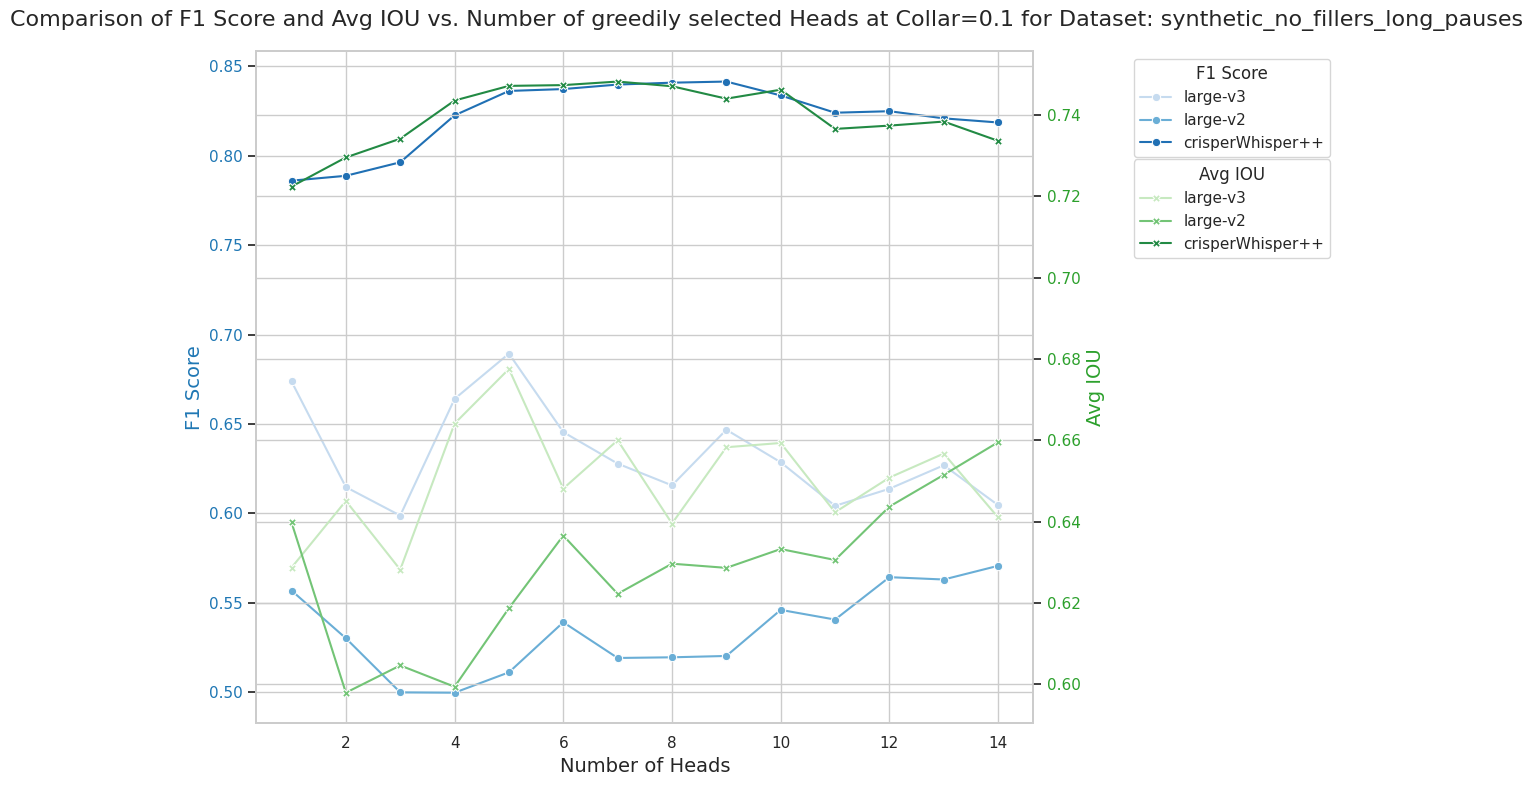

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
for dataset in visualization_config["visualization_datasets"]:
    collar = .1
    threshold = 0.1 #threshold for splitting pauses
    filtered_df = df[df['Collar'] == collar]
    filtered_df = filtered_df[filtered_df['MedianFilterWidth'] == 3]
    filtered_df = filtered_df[filtered_df['Threshold'] == threshold]
    filtered_df = filtered_df[filtered_df['Model'].isin(visualization_config["models_to_compare"])]
    filtered_df = filtered_df[filtered_df['Dataset'] == dataset]
    # Set the plotting style
    sns.set(style="whitegrid")
    
    # Initialize the matplotlib figure
    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    # Define colors and markers for better distinction
    color_f1 = 'tab:blue'
    color_iou = 'tab:green'
    marker_f1 = 'o'
    marker_iou = 'X'
    
    # Plotting F1 Score on the first y-axis
    f1_lines = sns.lineplot(data=filtered_df, x='num_heads', y='F1 Score', hue='Model', marker=marker_f1, ax=ax1, palette='Blues')
    ax1.set_xlabel('Number of Heads', fontsize=14)
    ax1.set_ylabel('F1 Score', fontsize=14, color=color_f1)
    ax1.tick_params(axis='y', labelcolor=color_f1)
    ax1.legend(title='Model (F1 Score)', bbox_to_anchor=(1.12, 1), loc='upper left')
    
    
    #ax1.axhline(y=whisper_t_f1_value, color='red', linestyle='--', linewidth=2, label='F1 Baseline')
    ax1.legend(title='F1 Score', bbox_to_anchor=(1.12, 1), loc='upper left')
    
    # Create a second y-axis for Avg IOU, sharing the same x-axis
    ax2 = ax1.twinx()
    iou_lines = sns.lineplot(data=filtered_df, x='num_heads', y='Avg IOU', hue='Model', marker=marker_iou, ax=ax2, palette='Greens')
    ax2.set_ylabel('Avg IOU', fontsize=14, color=color_iou)
    ax2.tick_params(axis='y', labelcolor=color_iou)
    ax2.legend(title='Model (Avg IOU)', bbox_to_anchor=(1.12, 0.85), loc='upper left')
    ax2.legend(title='Avg IOU', bbox_to_anchor=(1.12, 0.85), loc='upper left')
    
    # Title and layout adjustment
    fig.suptitle(f'Comparison of F1 Score and Avg IOU vs. Number of greedily selected Heads at Collar={collar} for Dataset: {dataset}', fontsize=16)
    plt.tight_layout()
    

    plt.savefig(os.path.join(visualization_config['output_path'], f'Average_F1_IOU_vs_number_of_heads_collar_{collar}_dataset_{dataset}.png'))
    # Show the plot
    plt.show()

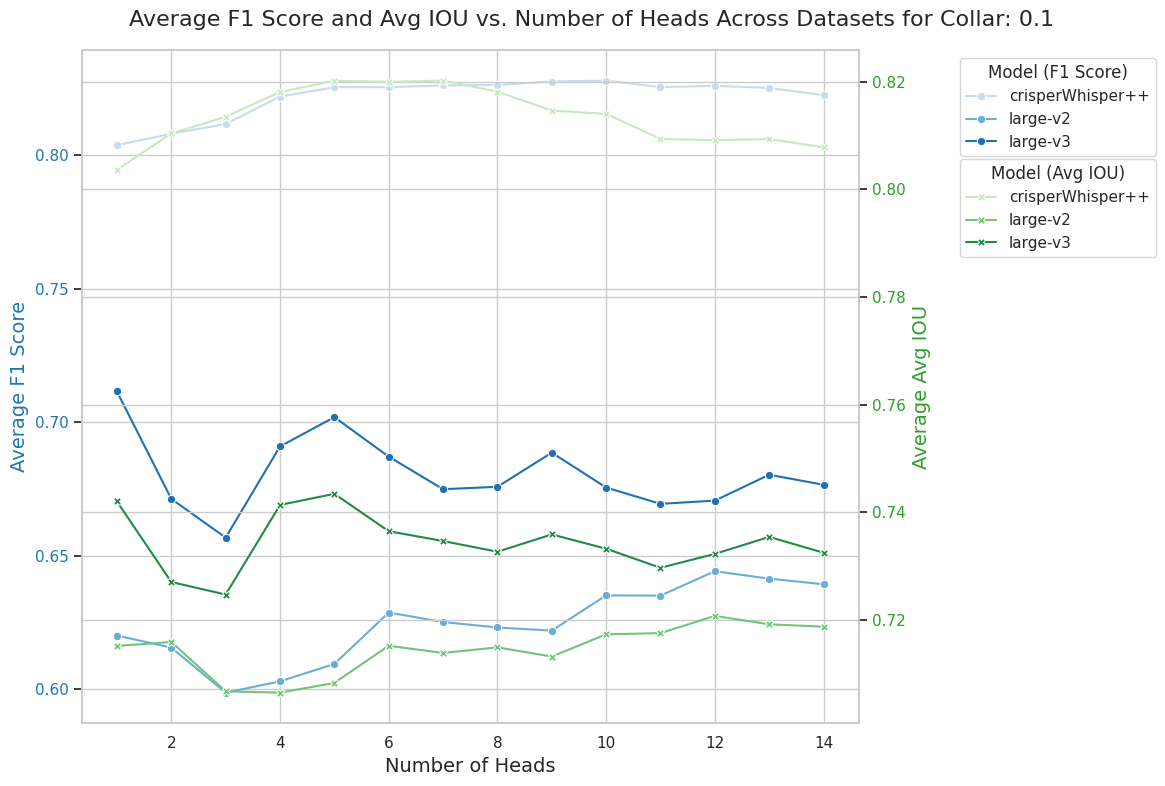

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named df
# Calculate the mean F1 Score and Avg IOU for each Model and num_heads
collar = .1
filtered_df = df[df['Collar'] == collar]
filtered_df = filtered_df[filtered_df['Model'].isin(visualization_config["models_to_compare"])]
filtered_df = filtered_df[filtered_df['MedianFilterWidth'] == 3]
filtered_df = filtered_df[filtered_df['Threshold'] == 0.1]  #threshold for splitting pauses
grouped_df = filtered_df.groupby(['Model', 'num_heads']).agg({
    'F1 Score': 'mean',
    'Avg IOU': 'mean',
    'F1 Score': 'mean',
    'Avg IOU': 'mean'
}).reset_index()

# Set the plotting style
sns.set(style="whitegrid")

# Initialize the matplotlib figure
fig, ax1 = plt.subplots(figsize=(12, 8))

# Colors for the two metrics
colors = ['tab:blue', 'tab:green']

# Plot F1 Score
sns.lineplot(data=grouped_df, x='num_heads', y='F1 Score', hue='Model', ax=ax1, palette='Blues', marker='o')
ax1.set_xlabel('Number of Heads', fontsize=14)
ax1.set_ylabel('Average F1 Score', fontsize=14, color=colors[0])
ax1.tick_params(axis='y', labelcolor=colors[0])

# Create a second y-axis for Avg IOU
ax2 = ax1.twinx()
sns.lineplot(data=grouped_df, x='num_heads', y='Avg IOU', hue='Model', ax=ax2, palette='Greens', marker='X')
ax2.set_ylabel('Average Avg IOU', fontsize=14, color=colors[1])
ax2.tick_params(axis='y', labelcolor=colors[1])

# Add legends
ax1.legend(title='Model (F1 Score)', bbox_to_anchor=(1.12, 1), loc='upper left')
ax2.legend(title='Model (Avg IOU)', bbox_to_anchor=(1.12, 0.85), loc='upper left')

# Title and layout adjustment
fig.suptitle(f'Average F1 Score and Avg IOU vs. Number of Heads Across Datasets for Collar: {collar}', fontsize=16)
plt.tight_layout()


plt.savefig(os.path.join(visualization_config['output_path'], f'Average_F1_IOU_vs_number_of_heads_collar_{collar}.png'))
# Show the plot
plt.show()

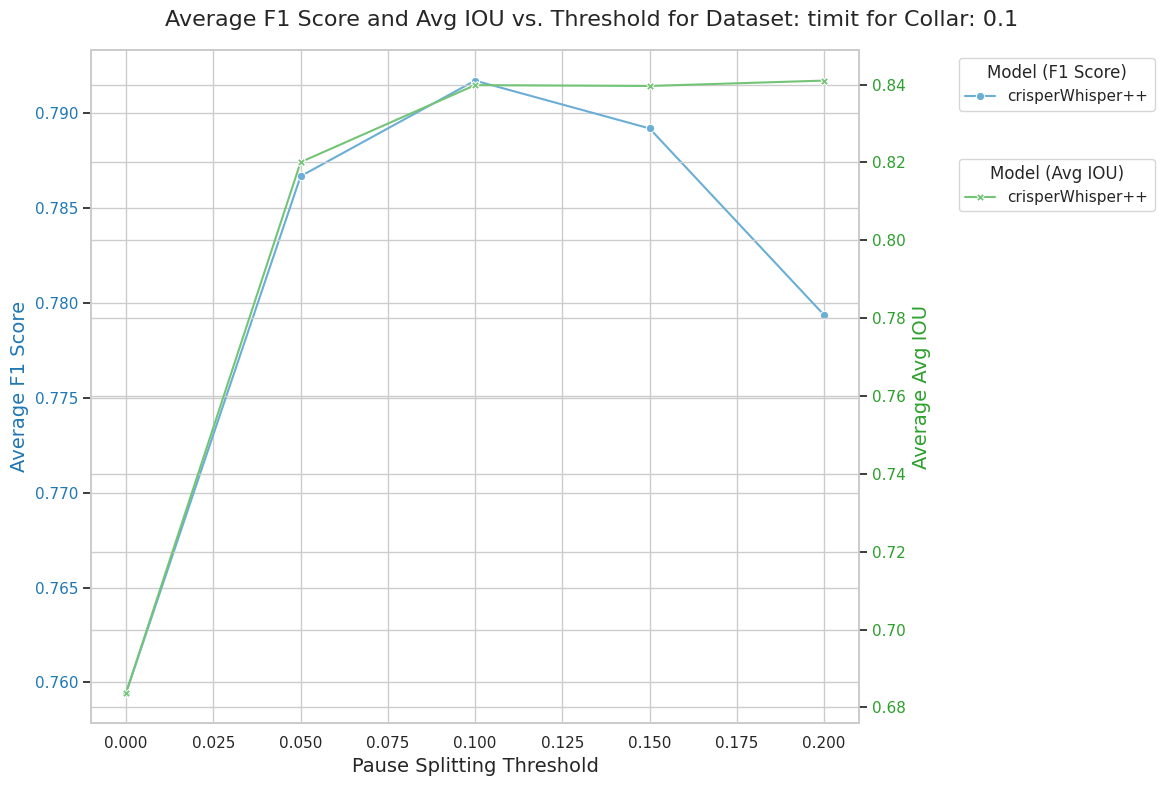

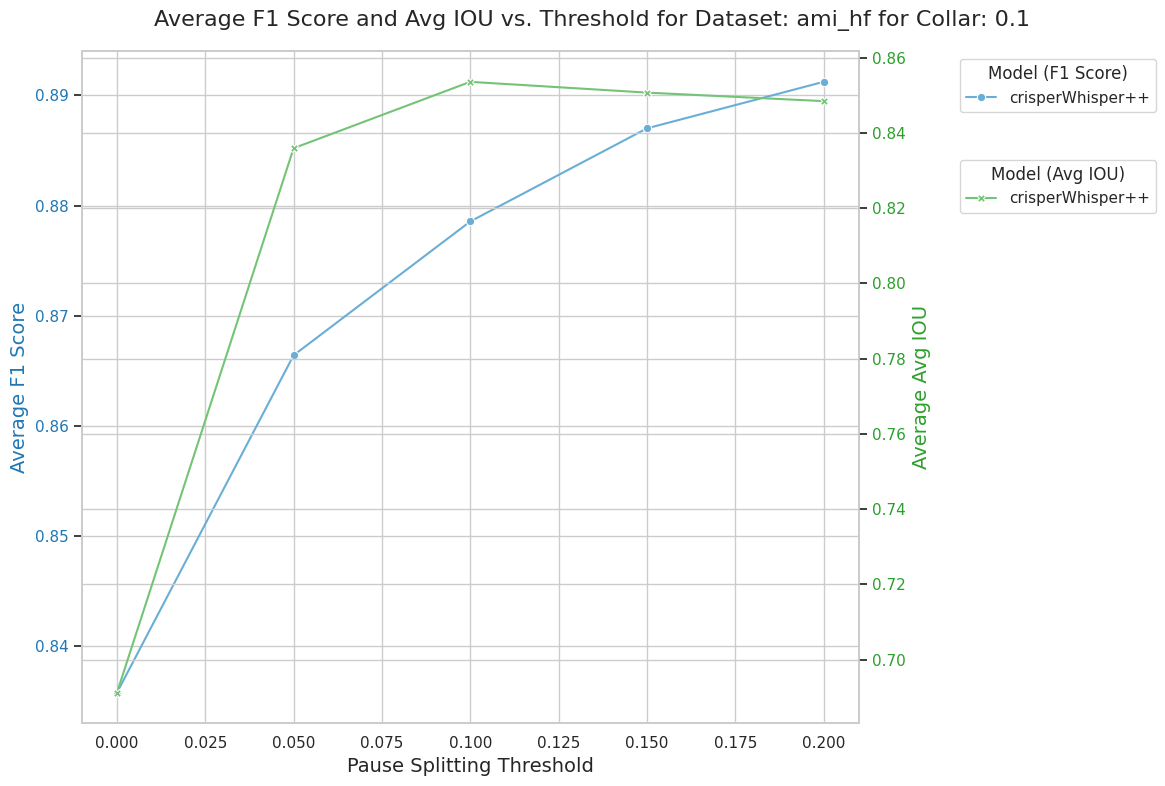

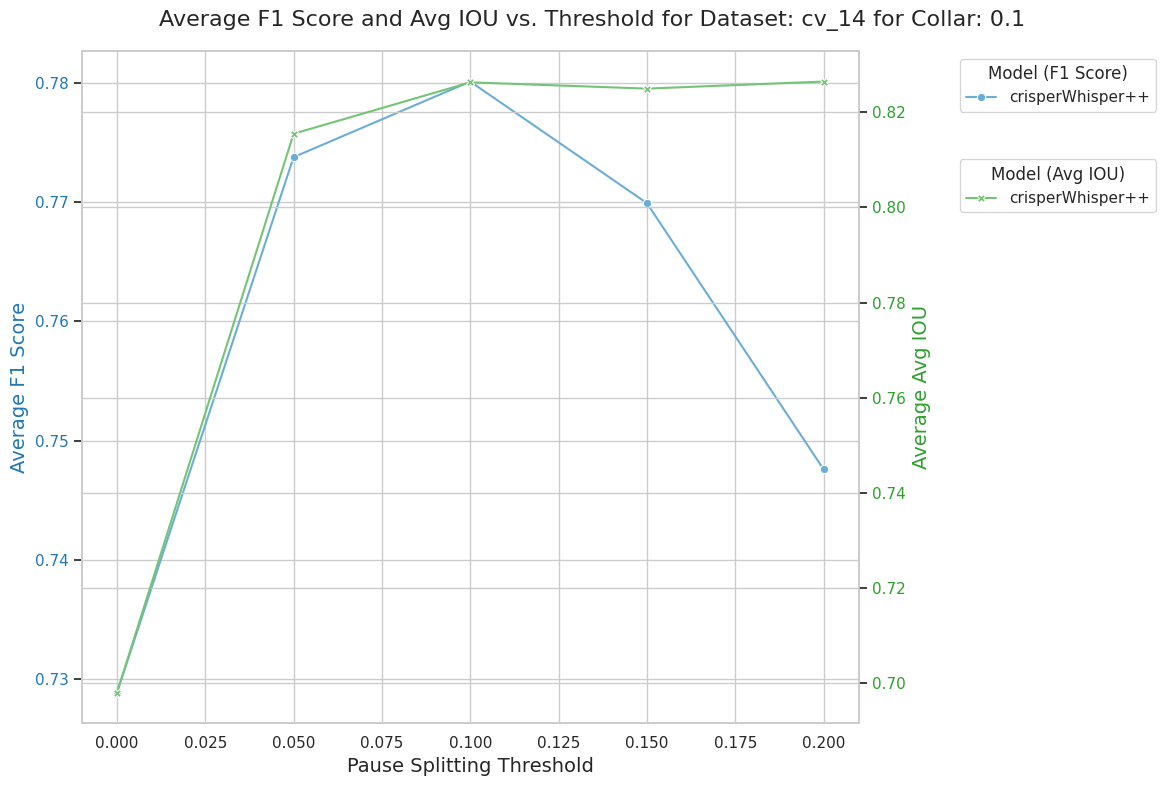

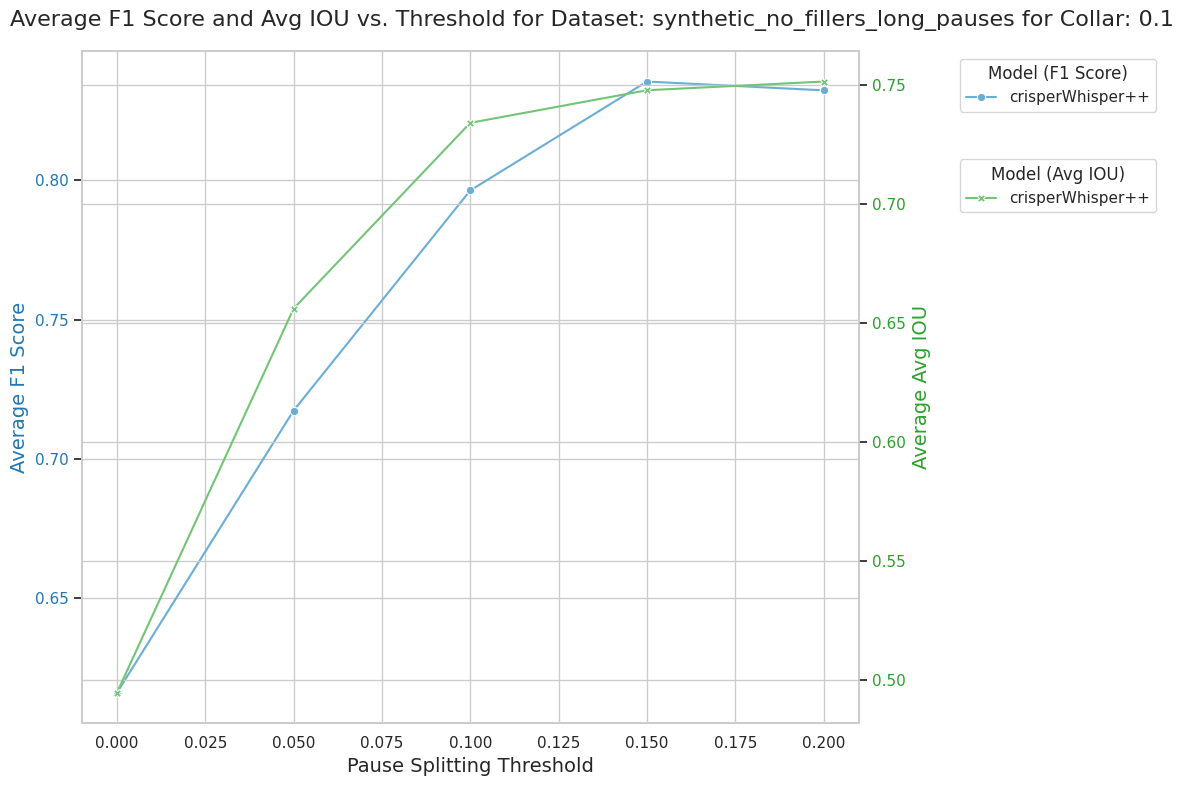

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named df
# Calculate the mean F1 Score and Avg IOU for each Model and num_heads
for dataset in visualization_config['visualization_datasets']:
    # Feel free to play around with these values
    collar = .1
    filtered_df = df[df['Collar'] == collar]
    filtered_df = filtered_df[filtered_df['Dataset'] == dataset]
    filtered_df = filtered_df[filtered_df['MedianFilterWidth'] == 3]
    filtered_df = filtered_df[filtered_df['num_heads'] == 3]
    filtered_df = filtered_df[filtered_df['Model'].isin(['crisperWhisper++'])]
    grouped_df = filtered_df.groupby(['Model', 'Threshold']).agg({
        'F1 Score': 'mean',
        'Avg IOU': 'mean',
    }).reset_index()
    
    # Set the plotting style
    sns.set(style="whitegrid")
    
    # Initialize the matplotlib figure
    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    # Colors for the two metrics
    colors = ['tab:blue', 'tab:green']
    
    # Plot F1 Score
    sns.lineplot(data=grouped_df, x='Threshold', y='F1 Score', hue='Model', ax=ax1, palette='Blues', marker='o')
    ax1.set_xlabel('Pause Splitting Threshold', fontsize=14)
    ax1.set_ylabel('Average F1 Score', fontsize=14, color=colors[0])
    ax1.tick_params(axis='y', labelcolor=colors[0])
    
    # Create a second y-axis for Avg IOU
    ax2 = ax1.twinx()
    sns.lineplot(data=grouped_df, x='Threshold', y='Avg IOU', hue='Model', ax=ax2, palette='Greens', marker='X')
    ax2.set_ylabel('Average Avg IOU', fontsize=14, color=colors[1])
    ax2.tick_params(axis='y', labelcolor=colors[1])
    
    # Add legends
    ax1.legend(title='Model (F1 Score)', bbox_to_anchor=(1.12, 1), loc='upper left')
    ax2.legend(title='Model (Avg IOU)', bbox_to_anchor=(1.12, 0.85), loc='upper left')
    
    # Title and layout adjustment
    fig.suptitle(f'Average F1 Score and Avg IOU vs. Threshold for Dataset: {dataset} for Collar: {collar}', fontsize=16)
    plt.tight_layout()

    plt.savefig(os.path.join(visualization_config['output_path'], f'Average_F1_IOU_vs_pause_splitting_threshold_dataset_{dataset}_collar_{collar}.png'))
    
    # Show the plot
    plt.show()

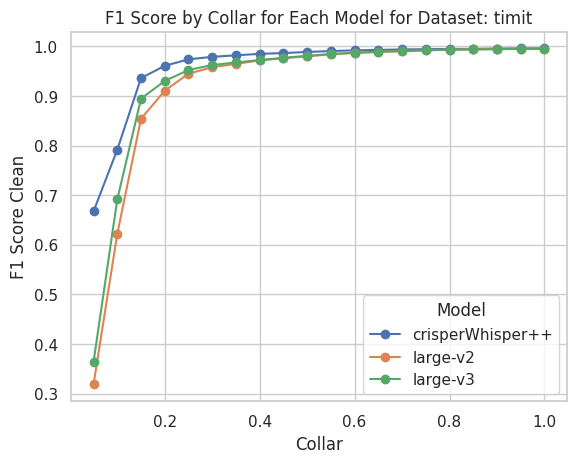

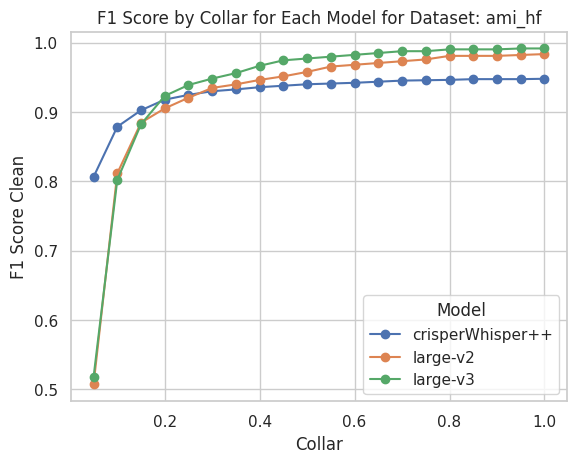

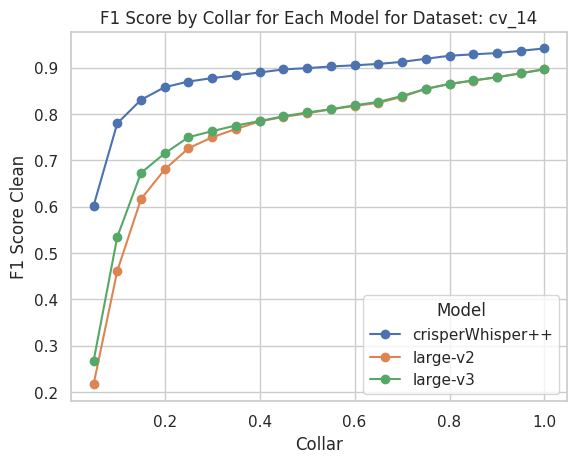

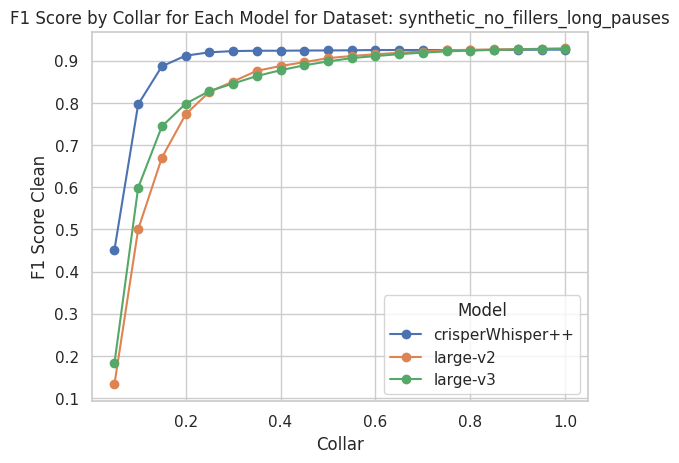

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

for dataset in visualization_config['visualization_datasets']:
    # Define thresholds for each model (customize this as needed)
    filtered_df = df[df['Threshold'] == .1]
    filtered_df = filtered_df[filtered_df['num_heads'] == 3]
    filtered_df = filtered_df[filtered_df['Dataset'] == dataset]
    filtered_df = filtered_df[filtered_df['MedianFilterWidth'] == 3]
    fig, ax = plt.subplots()
    for model, group in filtered_df.groupby('Model'):
        ax.plot(group['Collar'], group['F1 Score'], label=model, marker='o')
    
    ax.set_xlabel('Collar')
    ax.set_ylabel('F1 Score Clean')
    ax.set_title(f'F1 Score by Collar for Each Model for Dataset: {dataset}')
    ax.legend(title='Model')

    plt.savefig(os.path.join(visualization_config['output_path'], f'Average_F1_vs_collar_dataset_{dataset}.png'))
    
    plt.show()

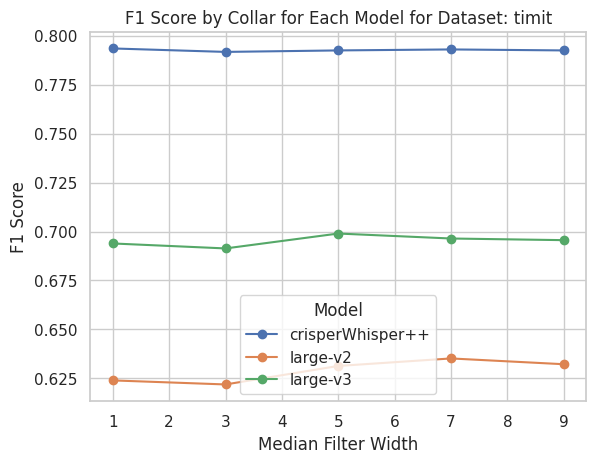

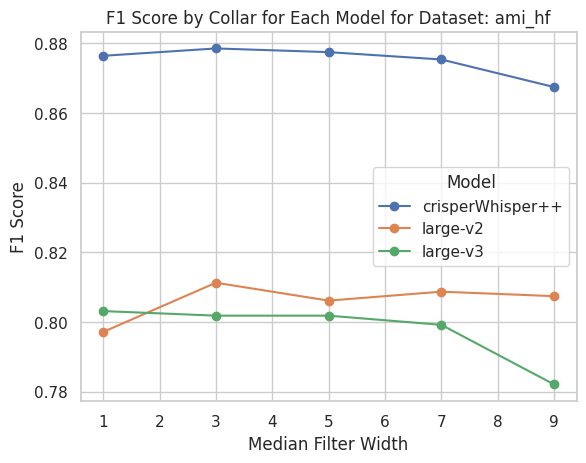

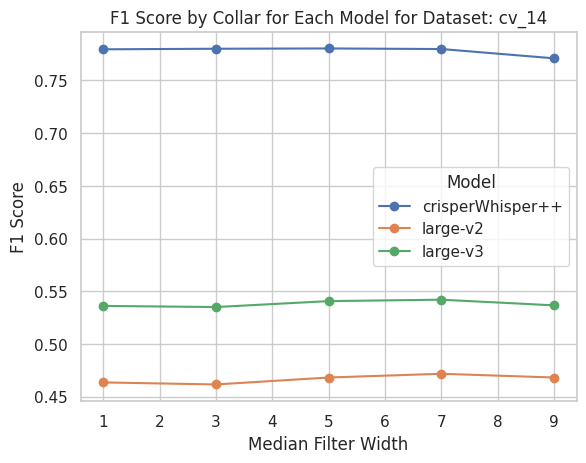

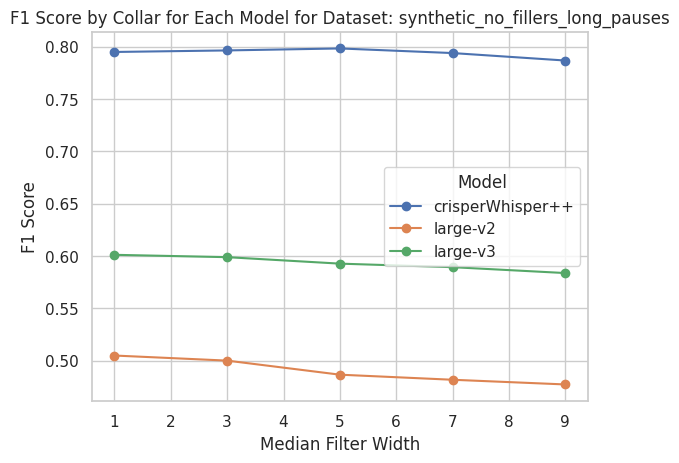

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

for dataset in visualization_config['visualization_datasets']:
    collar =.1
    filtered_df = df[df['Threshold'] ==.1]
    filtered_df = filtered_df[filtered_df['num_heads'] == 3]
    filtered_df = filtered_df[filtered_df['Dataset'] == dataset]
    filtered_df = filtered_df[filtered_df['Collar'] == collar]
    fig, ax = plt.subplots()
    for model, group in filtered_df.groupby('Model'):
        ax.plot(group['MedianFilterWidth'], group['F1 Score'], label=model, marker='o')
    
    ax.set_xlabel('Median Filter Width')
    ax.set_ylabel('F1 Score')
    ax.set_title(f'F1 Score by Collar for Each Model for Dataset: {dataset}')
    ax.legend(title='Model')
    plt.savefig(os.path.join(visualization_config['output_path'], f'Average_F1_vs_median_filter_width_dataset_{dataset}_collar_{collar}.png'))
        
    plt.show()